In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import MissingIndicator, KNNImputer,SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


##Importation de données

In [ ]:
!pip install gdown
file_id = '1TW5MxPuuuMHhJOO7adxC9Aj3JV7aZGZW'
gdown_url = f'https://drive.google.com/uc?id={file_id}'
output_file = 'ebooks.csv'
!gdown {gdown_url} -O {output_file}
!pip install missingno

Downloading...
From: https://drive.google.com/uc?id=1TW5MxPuuuMHhJOO7adxC9Aj3JV7aZGZW
To: /content/ebooks.csv
100% 73.3M/73.3M [00:01<00:00, 70.4MB/s]


In [ ]:
df = pd.read_csv(output_file)
df.drop(columns=['origin_file'], inplace=True)
display(df.head(5))

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 02:20:47 UTC,view,5200007,2053013553316626707,computers.ebooks,pocketbook,99.68,553879242,081ff3cf-2f3c-40ab-a96e-8224875c2e78
1,2019-10-01 02:41:40 UTC,view,5200131,2053013553316626707,computers.ebooks,pocketbook,128.45,512840416,f77aa50f-1f31-4543-8aff-e7aeca10d426
2,2019-10-01 02:41:53 UTC,view,5200131,2053013553316626707,computers.ebooks,pocketbook,128.45,512840416,f77aa50f-1f31-4543-8aff-e7aeca10d426
3,2019-10-01 02:42:03 UTC,view,5200131,2053013553316626707,computers.ebooks,pocketbook,128.45,512840416,f77aa50f-1f31-4543-8aff-e7aeca10d426
4,2019-10-01 02:51:48 UTC,view,5200090,2053013553316626707,computers.ebooks,amazon,257.38,540004194,3dbd81be-d970-491a-85c6-00d641dd6ba1


##Nettoyage et transformation de données





In [ ]:
#Changement du type de données
df['event_time'] = pd.to_datetime(df['event_time']).dt.tz_localize(None)
df['event_time'] = df['event_time'].dt.date

# Conversion des autres colonnes vers des types appropriés (string)
df['event_type'] = df['event_type'].astype("string")
df['product_id'] = df['product_id'].astype("string")
df['category_id'] = df['category_id'].astype("string")
df['category_code'] = df['category_code'].astype("string")
df['brand'] = df['brand'].astype("string")
df['user_id'] = df['user_id'].astype("string")
df['user_session'] = df['user_session'].astype("string")

df.describe(include = "all")

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
count,480136,480136,480136,480136,480136,466950,480136.000000,480136,480136
unique,213,3,1344,4,1,67,NaN,141130,201563
top,2019-11-16,view,5200131,2053013553316626707,computers.ebooks,pocketbook,NaN,619573377,41f7ade8-dc14-4ed7-85a8-9bb96a347099
freq,5269,459607,29461,272442,480136,187393,NaN,285,190
mean,NaN,NaN,NaN,NaN,NaN,NaN,122.286344,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,101.472598,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,34.750000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,102.940000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,162.090000,NaN,NaN


In [ ]:
#Encoding des variables categorielles
df['user_session'] = pd.factorize(df['user_session'])[0]
df['category_id'] = pd.factorize(df['category_id'])[0]
df['product_id'] = pd.factorize(df['product_id'])[0]
df['user_id'] = pd.factorize(df['user_id'])[0]
df['event_type_nb'] = pd.factorize(df['event_type'])[0]
df['brand_nb'] = pd.factorize(df['brand'])[0]
df['event_time_nb'] = pd.factorize(df['event_time'])[0]

display(df.head(5))

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_type_nb,brand_nb,event_time_nb
0,2019-10-01,view,0,0,computers.ebooks,pocketbook,99.68,0,0,0,0,0
1,2019-10-01,view,1,0,computers.ebooks,pocketbook,128.45,1,1,0,0,0
2,2019-10-01,view,1,0,computers.ebooks,pocketbook,128.45,1,1,0,0,0
3,2019-10-01,view,1,0,computers.ebooks,pocketbook,128.45,1,1,0,0,0
4,2019-10-01,view,2,0,computers.ebooks,amazon,257.38,2,2,0,1,0


In [ ]:
#calculer les métriques par produit
product_features = df.groupby('product_id').agg({
    'price': ['mean'],                                 # Prix moyen
    'brand': 'nunique',                                # Diversité des marques (si pertinent)
    'user_id': 'nunique',                              # Nombre d'utilisateurs uniques ayant interagi avec ce produit
    'event_type': lambda x: x.value_counts().to_dict() # Fréquence des types d'événements (view, cart, purchase)
}).reset_index()

In [ ]:
#renommer les colonnes
product_features.columns = ['product_id', 'avg_price', 'unique_brands', 'unique_users', 'event_type']

In [ ]:
#convertir les types d'événtments en colonne
event_types = product_features['event_type'].apply(pd.Series).fillna(0)
event_types.columns = [f"event{col}" for col in event_types.columns]
product_features = pd.concat([product_features.drop(columns=['event_type']), event_types], axis=1)

In [ ]:
#normaliser les données
features = ['avg_price', 'unique_brands', 'unique_users'] + list(event_types.columns)
scaler = StandardScaler()
X = scaler.fit_transform(product_features[features])

##Modélisation : K-means

Définition du nombre de cluster

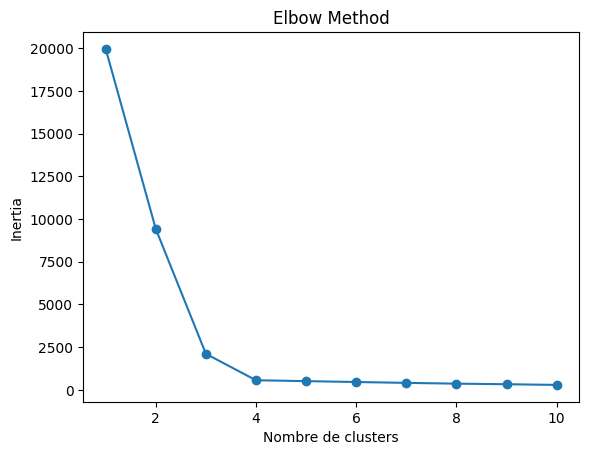

In [ ]:
#méthode Elbow

# Exemple de données simulées
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=300, centers=4, random_state=42)

# Calcul des inerties pour différents nombres de clusters
inertias = []
for k in range(1, 11):  # Test de 1 à 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Traçage de la courbe Elbow
plt.plot(range(1, 11), inertias, marker='o')
plt.title("Elbow Method")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertia")
plt.show()


Dans la méthode Elbow, le nombre optimal de clusters est généralement situé au niveau du "coude" de la courbe. Le "coude" est le point où l'inertie commence à diminuer beaucoup plus lentement après une forte chute initiale.



---
Observation de la courbe :

Entre 1 et 3 clusters, l'inertie diminue fortement, indiquant une nette amélioration de la compacité des clusters.
Après 3 clusters, la réduction de l'inertie devient plus faible, ce qui montre que l'ajout de clusters supplémentaires n'améliore que légèrement la qualité du regroupement.
Position du coude :

Le "coude" du graphe semble apparaître autour de 3 clusters.
Cela signifie qu'à partir de ce point, l'inertie diminue beaucoup moins vite, suggérant que 3 clusters est un compromis optimal entre précision et simplicité.


---



Le nombre optimal de clusters pour nos données est 3.
Cela signifie que diviser vos données en 3 groupes permettra d'obtenir des clusters compacts tout en limitant la complexité du modèle.

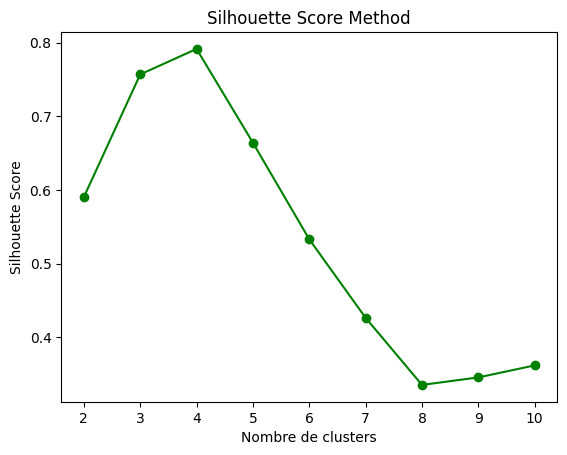

In [ ]:
#méthode silhouette score

from sklearn.metrics import silhouette_score

# Calcul des silhouette scores pour différents nombres de clusters
silhouette_scores = []
for k in range(2, 11):  # Silhouette ne fonctionne qu'à partir de 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

# Traçage de la courbe Silhouette
plt.plot(range(2, 11), silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score Method")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette Score")
plt.show()


La méthode Silhouette Score permet d'évaluer la qualité des clusters pour différents nombres de clusters. Elle mesure à quel point chaque point est correctement regroupé dans son cluster tout en étant distinct des autres clusters.

Silhouette Score élevé : Une valeur proche de 1 signifie que les clusters sont bien définis et distincts.
Silhouette Score faible ou négatif : Les points sont mal classés ou se chevauchent entre clusters.
Le nombre optimal de clusters correspond au score le plus élevé, indiquant la meilleure séparation des données.


---
Analyse des valeurs :

Le Silhouette Score augmente fortement pour passer de 2 clusters à 4 clusters, atteignant son maximum à 4 clusters (~0.8).
Ensuite, le score diminue progressivement avec l'augmentation du nombre de clusters, indiquant une perte de la qualité de segmentation.
Signification :

Le score maximal à 4 clusters signifie que diviser les données en 4 groupes permet d'obtenir des clusters compacts et bien séparés.
Ajouter plus de clusters ne fait que dégrader la qualité de segmentation en introduisant du bruit.



---
Selon la méthode du Silhouette Score, le nombre optimal de clusters pour vos données est 4.


**justification du choix du nombre clusters**

Pour la simplicité et un modèle plus léger et interprétable : **3 clusters (selon Elbow).**
Cela convient pour des segments plus généraux.

Pour une meilleure qualité de clustering et des segments plus précis : ** 4 clusters (selon Silhouette Score).**


Cela convient lorsque vous avez besoin d'une meilleure différenciation entre les groupes.

Appliquer K-means

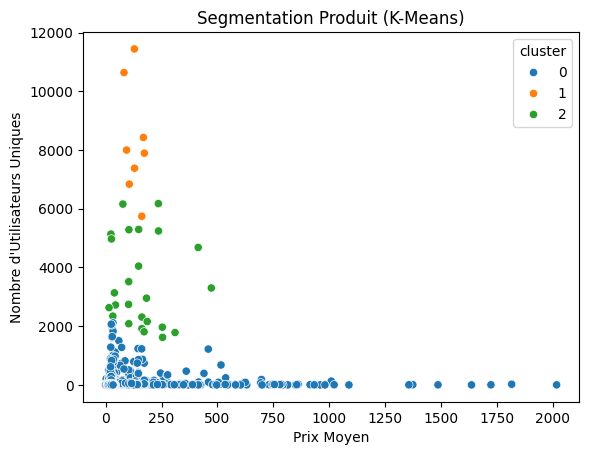

In [ ]:
# 3 CLUSTERS
kmeans = KMeans(n_clusters=3, random_state=42)


features_for_clustering = ['avg_price', 'unique_brands', 'unique_users'] + list(event_types.columns)
product_features['cluster'] = kmeans.fit_predict(product_features[features_for_clustering])


sns.scatterplot(
    x=product_features['avg_price'],
    y=product_features['unique_users'],
    hue=product_features['cluster'],
    palette="tab10"
)
plt.title("Segmentation Produit (K-Means)")
plt.xlabel("Prix Moyen")
plt.ylabel("Nombre d'Utilisateurs Uniques")
plt.show()

**Interprétation 3 clusters**

*   **Cluster 0 (bleu)** = Regroupe les produits avec des prix moyens élevés mais très peu d'utilisateurs uniques.
*   **Cluster 1 (orange)** = Composé de produits à prix bas mais avec un grand nombre d'utilisateurs uniques.
*   **Cluster 2 (vert)** = Ce groupe contient des produits avec des prix modérés et un nombre moyen d'utilisateurs uniques.




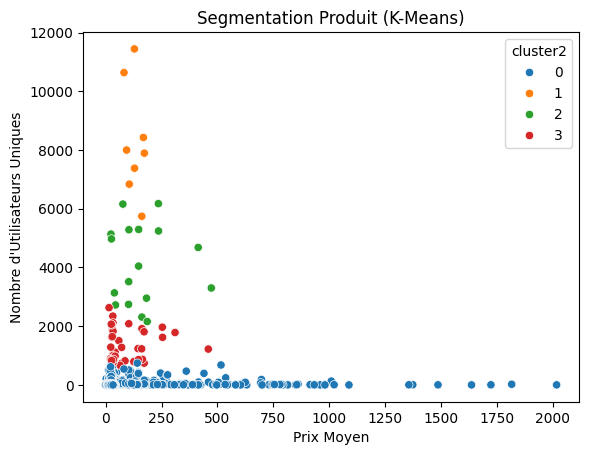

In [ ]:
# 4 CLUSTER

from sklearn.preprocessing import StandardScaler



kmeans2 = KMeans(n_clusters=4, random_state=42)  # Choisir un nombre de clusters adapté


features_for_clustering = ['avg_price', 'unique_brands', 'unique_users'] + list(event_types.columns)
product_features['cluster2'] = kmeans2.fit_predict(product_features[features_for_clustering])


sns.scatterplot(
    x=product_features['avg_price'],
    y=product_features['unique_users'],
    hue=product_features['cluster2'],
    palette="tab10"
)
plt.title("Segmentation Produit (K-Means)")
plt.xlabel("Prix Moyen")
plt.ylabel("Nombre d'Utilisateurs Uniques")
plt.show()

**Interprétation 4 clusters**

*   **Cluster 0 (bleu)** = Produits chers avec un faible nombre d'utilisateurs.

*   **Cluster 1 (orange)** = Produits peu chers avec un grand nombre d'utilisateurs.

*   **Cluster 2 (vert)** = Produits de prix moyen avec un nombre d'utilisateurs modéré.

*   **Cluster 3 (rouge)** = Produits bon marché avec un faible nombre d'utilisateurs.

## Evaluation du modèle

In [ ]:
#inertie intra cluster (3 clusters)
inertia = kmeans.inertia_
print(f'Inertia: {inertia:.2f}')

#inertie intra cluster (4 clusters)
inertia = kmeans2.inertia_
print(f'Inertia: {inertia:.2f}')

Inertia: 630423192.30
Inertia: 432847204.75




L'inertie intra-cluster mesure la somme des distances au carré entre chaque point d’un cluster et son centroïde. C’est un indicateur de compacité des clusters. Plus cette valeur est faible, plus les points sont proches du centroïde, ce qui signifie que les clusters sont bien définis et compacts.



---



**630423192.30** :

* Le résultat est très élevé.
* Les clusters ne sont pas encore optimaux : Les données pourraient être trop dispersées ou mal segmentées.
* Les distances entre les points et leurs centroïdes sont grandes, ce qui signifie que la compacité des clusters n’est pas encore optimale.



---
**432847204.75** :

* Le résultat est dimunué.
* Les clusters ne sont pas encore optimaux : Les données pourraient être trop dispersées ou mal segmentées.
* Les distances entre les points et leurs centroïdes sont grandes, ce qui signifie que la compacité des clusters n’est pas encore optimale.





In [ ]:
#silhouette_score = 3 clusters
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

silhouette_avg = silhouette_score(X, labels)
print(f"Silhouette Score pour {n_clusters} clusters : {silhouette_avg:.4f}")

#silhouette_score = 4 clusters
n_clusters = 4
kmeans2 = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans2.fit_predict(X)

silhouette_avg = silhouette_score(X, labels)
print(f"Silhouette Score pour {n_clusters} clusters : {silhouette_avg:.4f}")

Silhouette Score pour 3 clusters : 0.7569
Silhouette Score pour 4 clusters : 0.7916


Le Silhouette Score est compris entre -1 et 1 :
* Proche de 1 : Les clusters sont bien définis, compacts et séparés.
* Proche de 0 : Les clusters sont proches les uns des autres ou se chevauchent.
* Négatif : Les points sont mal attribués aux clusters.

---

Avec **0.7569** ou **0.7916**, le résultat est excellent, ce qui signifie que :
Les clusters sont cohérents.
Les points sont bien regroupés dans leurs clusters respectifs.
Les clusters sont suffisamment séparés les uns des autres.